In [1]:
%matplotlib inline

#version 1

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display
display(HTML("<style> .container { width:100%; }</style>")) #jupyter full screen width
display(HTML("<style> .CodeMirror pre { font-size: 12pt; line-height: 110%;} </style>")) #jupyter font
figSize = (18,12) #figure size
lW = 1 #line width for graphs


In [2]:
pLen      = 1     # pendulum length, meters
pLenError = 0.5   # pendulum length error. TRY VARIOUS VALUES
g = 9.81          # gravitational acceleration
dT = 0.01         # simulation time increment
dt = dT
N = 500           # time steps
aVel = 0             # initial angular velocity
iAngle     = np.pi/20  #initial angle
iAngleError = 0.03     #initial angle error. TRY VARIOUS VALUES

angl = iAngle
time = 0
vx = [] 
al = []
av = []
tList = []
angleList = []

for i in range(N):
    vx.append(aVel*pLen*np.cos(angl))
    al.append(g*np.cos(angl) - aVel*aVel*pLen)
    av.append(g*np.sin(angl))    
    angleList.append(angl)
    tList.append(time)
    
    time = time + dT
    aVel = aVel +  g * np.sin(angl) * dT /pLen
    angl = angl -  aVel * dT

vxSS    = 0.5 # radar vx variance. TRY VARIOUS VALUES
vxBias  = 0.05 # radar systematic error. TRY VARIOUS VALUES
vx = vx + np.random.normal(vxBias, vxSS, N) 

alSS    = 0.5 # accelerometer variance. TRY VARIOUS VALUES
alBias  = 0.05 # accelerometer systematic error. TRY VARIOUS VALUES
al = al + np.random.normal(alBias, alSS, N) 

avSS    = 0.02 # accelerometer variance. TRY VARIOUS VALUES
avBias  = 0.01 # accelerometer systematic error. TRY VARIOUS VALUES
av = av + np.random.normal(avBias, avSS, N) 

inData = np.stack((tList, vx, [vxSS+vxBias*vxBias] * N, al, [alSS+alBias*alBias] * N, av, [avSS+avBias*avBias] * N)).T

# Algorithm Description

### Sensors description
Radar 
- gives horizontal speed magnitude (vx)
- suffers from drift over time

Accelerometer 
- gives acceleration vectors (av; al)
- affected by noisy vibrations
- useful for filtering noise is a low pass filter

### Solutions comparison

#### Complementary Filter
A complementary filter is, in the simplest words, a low pass filter concatened with a high pass filter. I have listed advantages and disadvantages below and, although, it is a simpler solution to code, I decided that it doesn't give me the flexibility I need to describe the whole system and take into account all the data I have at my disposal.

Advantages:
- easy to understand
- easy to implement

Disadvantages:
- it does not give the best estimation possible

This method is very useful to reject momentarily acceleration errors from an accelerometer (using a low pass filter) and gyroscope drift (using a high pass filter).

#### (Extended) Kalman Filter (solution used)
To solve the assignment, an extended Kalman filter is needed because of the non-linearity of the trigonometric functions used to describe the motion of the pendulum.

Advantages:
- takes into account known physical properties of the pendulum
- using the true input signal to give the best estimation possible
- flexible (useful for any given input state)
- covariance matrices updates at each step

Disadvantages:
- hard to describe the physical system. 
- very challenging to understand and to implement.
- EKF is not necessarily the most efficient way to solve the problem.
- it takes a lot of processor time. Is not good to implement on embedded systems.

EKF algorithm has 2 important steps. 
1. The prediction - calculate $ \hat x $. During this step, the next state is computed using the physical description of the system.
2. The update - calculate $ \hat x' $. Depending on how much we trust either $ \hat x $ or z (the trust is tweaked using matrices Q and R), the best estimation $ \hat x' $ will be computed based on $ \hat x $ and z.

### (Extended) Kalman system description (online computation)

Below I have describe the main functions and matrices used to implement EKF.

- The x state contains the angle, angular speed and angular acceleration.
\begin{gather}
x = \begin{bmatrix}
           \theta \\
           \dot\theta \\
           \ddot\theta
     \end{bmatrix}
   = \begin{bmatrix}
           \theta \\
           \omega \\
           \alpha
     \end{bmatrix}
\end{gather}

- The z state contains the measurements from the sensors (with errors and biases)
\begin{gather}
z = \begin{bmatrix}
    vx \\
    av \\
    al
    \end{bmatrix}
\end{gather}

- The f(x) function is composed of formulas - a description of the physical system.
\begin{gather}
f(x) = \begin{bmatrix}
    \theta_{k-1} + \omega_{k-1} * \Delta t + \alpha_{k-1} * \frac{(\Delta t)^2}{2}\\
    \omega_{k-1} + \alpha_{k-1} * \Delta t\\
    g sin(\theta_{k-1})
    \end{bmatrix}
\end{gather}

\begin{gather}
Jacobian(f(x)) = \begin{bmatrix}
    1 & \Delta t & \frac{(\Delta t)^2}{2} \\
    0 & 1 & \Delta t \\
    gsin(\theta) & 0 & 0
    \end{bmatrix}
\end{gather}

- The h(x) function is used to project the x state into the z space
\begin{gather}
h(x) = \begin{bmatrix}
    \omega l cos(\theta) \\
    g sin(\theta) \\
    g cos(\theta) - \omega^2l
    \end{bmatrix}
\end{gather}

\begin{gather}
Jacobian(h(x)) = \begin{bmatrix}
    -\omega l sin(\theta) & l cos(\theta)  & 0 \\
    g cos(\theta) & 0 & 0 \\
    -g sin(\theta) & -2 \omega l & 0
    \end{bmatrix}
\end{gather}

- Because of the non-linearity observed, matrices F and H used in the predict step, respectively the update step are computed as Jacobians.

Implemented formulas for EKF are listed below:

1. Predict step:

$$ \hat x_k = f(x) $$

$$ P_k = Jacobian(F)P_{k-1}Jacobian(F)^T + Q $$

2. Update step:

$$ \hat x'_k = \hat x_k + K'(z_k - h(\hat x_k))$$

$$ P'_k = P_k - K'Jacobian(H)P_k $$

$$ K' = P_kJacobian(H)^T(Jacobian(H)P_kJacobian(H)^T + R)^{(-1)} $$

### Other computations (still online computation)
#### (First approach) Pendulum length
Firstly, I tried to add the length of the pendulum into the x state and into the z state. I was going to use the Kalman filter to predict the value of the length and then update it into the z vector (simulating a new better measurement of the length).

I plotted the result and observed that the length value was not converging toward the real value, it was oscilating towards a lower and lower value with time. This was happening because I was simulating in z a smaller and smaller value each time. Tweaking the R value to not trust the measurement as much was not a solution, so I tried something more robust -> physics formula (see below).

#### (Second approach) Pendulum length (used)
The steps of the algorithm are mentioned below:
1. Approximate period of the pendulum oscillations (1/2 of a period is from V = 0 to V = 0 again)
2. Get the estimated pendulum length from the next formula:

$T = 2\pi\sqrt(\frac{l}{g})$

This is still an online approximation because I am using online information form iterations k-1 and k. Also, while the Kalman filter is accurately estimating the angle, this method is computing almost the real length with a very small error.

#### Systematic errors of the sensors (tried, but not suceeded)
I have tried to add the angle_bias and angular_speed_bias into the x state of the Kalman filter, hoping that the algorithm will approximate them. But, afterwards, the filter was highly unstable for every change in bias or error.

#### Notes
1. To make the matrices (F and H) and initial state x of the EKF design, I have collaborated with Alexandru Meterez 342C1.
2. Other useful references that I read are listed in a cell at the end of the notebook.

In [3]:
# you need to improve this function 
# this solution does not improve use the radar data
# and, also, does not attempt to estimate the pendulum length, gyro and radar bias
# only works well if the gyro is accurate and has no bias.
# does not even use pendulum physics

# Kept and used to compare my algorithm results
def estimateGyroNaive(measurements, angle, pendLen, g):
    N = measurements.shape[0]
    oldT = 0
    aList = []
    for i in range(N):
        (t, vx, vxSS, al, alSS, av, avSS) = tuple(measurements[i,:])
        dt = t - oldT
        oldT = t

        angle = angle - vx / pendLen * dt # silly approximation v=v_x
        aList.append(angle)
    return (aList, pendLen, 0, 0, 0) 

In [4]:
def fx(x, g, dt):
    _theta = x.item(0)
    _omega = x.item(1)
    _alpha = x.item(2)
    return np.matrix([[_theta + _omega * dt + _alpha * dt * dt /2], [_omega + _alpha * dt], [g * np.sin(_theta)]])

In [5]:
def Jacobian_F(x, g, dt):
    _theta = x.item(0)
    _omega = x.item(1)
    _alpha = x.item(2)
    return np.matrix([[1, dt, dt * dt/2], [0, 1, dt], [g*np.cos(_theta), 0, 0]])

In [6]:
def hx(x, g, l):
    _theta = x.item(0)
    _omega = x.item(1)
    _alpha = x.item(2)
    return np.matrix([[_omega * l * np.cos(_theta)] ,[g * np.sin(_theta)], [g * np.cos(_theta) - _omega * _omega * l]]) 

In [7]:
def Jacobian_H(x, g, l):
    _theta = x.item(0)
    _omega = x.item(1)
    _alpha = x.item(2)
    return np.matrix([[-_omega * l * np.sin(_theta), l * np.cos(_theta), 0], [g * np.cos(_theta), 0, 0], [-g * np.sin(_theta), -2 * _omega * l, 0]])

In [8]:
def predict(_fx, _JF, P, Q):
    x_estimated = _fx
    P_estimated = _JF @ P @ np.transpose(_JF) + Q
    return (x_estimated, P_estimated)

In [9]:
def update(x_estimated, P_estimated, z, _hx, _JH, R):
    # Compute Kalman gain 
    K = P_estimated @ np.transpose(_JH) @ np.linalg.inv(_JH @ P_estimated @ np.transpose(_JH) + R)

    x_best_estimated = x_estimated + K @ (z - _hx)
    
    # Although this is mathematical correct, it is numerical instable. I used the improved formula below instead.
    # P_best_estimated = P_estimated - K @ _JH @ P_estimated
    I = np.eye(state_dim)
    P_best_estimated = (I - K @ _JH) @ P_estimated @ np.transpose(I - K @ _JH) + K @ R @ np.transpose(K) 
    return (x_best_estimated, P_best_estimated)

In [15]:
np.set_printoptions(precision = 6, suppress=True)

state_dim = 3
measurement_dim = 3

def estimateGyro(measurements, theta, l, g):
    N = measurements.shape[0]
    aList = []

    # Uncertainty from the real world. (i.e. wind is blowing and affecting the pendulum).
    # The physical model is pretty accurate and complete, so I trust the predicted values.
    Q = np.full(state_dim, 0.2) + np.eye(state_dim) * dt
    Q[state_dim - 1][state_dim - 1] = 15

    # Uncertainty from sensors (datasheet/calibration of sensor is not exact)
    R = np.eye(state_dim)

    # First guess of the initial position
    # x[0] = Theta x[1] = Omega x[2] = Alpha
    x = np.matrix([[0.2], [0.2 * g], [g]])
    
    # Initialization of covariance matrix P
    P = np.eye(state_dim)

    # Useful to approximate length
    oldTheta = 0
    period = 0
    length = l
    e_lList = []
    
    # EKF code
    for i in range(N):
        (t, vx, vxSS, al, alSS, av, avSS) = tuple(measurements[i,:])
        
        # z is read from sensors at each step
        z = np.matrix([[vx], [av], [al]])
        R = np.matrix([[vxSS, 0, 0], [0, avSS, 0], [0, 0, alSS]])

        # predict step
        fx_var = fx(x, g, dt)
        JF_var = Jacobian_F(x, g, dt)
        (x_e, P_e) = predict(fx_var, JF_var, P, Q)

        # update step
        hx_var = hx(x_e, g, l)
        JH_var = Jacobian_H(x_e, g, l)
        (x_be, P_be) = update(x_e, P_e, z, hx_var, JH_var, R)

        # Update everything for the next step
        P = P_be 
        x = x_be
        oldTheta = theta
        
        # Add the best estimation possible to the output
        theta = x_be.item(0)
        aList.append(theta)
        
        # Compute how much is lasting one period using the best estimated angle and physics (T = 2 * pi * sqrt(l/g))
        # Note 1: When the angle is changing the sign, it's passing through the equilibrium state. (half of a period)
        # Note 2: The first value is a quarter of a period and it's not used further in the algorithm
        # The length is computed online using only the measurements and approximations from t = 0 to k (present)
        period += dt
        if ((theta < 0 and oldTheta > 0) or (theta > 0 and oldTheta < 0) ):
            period = 2 * period
            length = (g * period * period) / (4 * np.pi * np.pi)
            e_lList.append(length)
            period = 0

    # Compute an average of pendulum lengths estimated
    real_l = np.average(e_lList[1:])
    l_bias = l - real_l
    
    # Covariance between position and speed (=> angle and angular speed) can be taken from P matrix. The index of this covariance is P[0][1]
    cov = P.item((0, 1))
    return (aList, real_l, 0, 0, 0, l_bias, cov) 

RMS Angle Estimation Error: 0.05175940687848915

Estimated position/speed covariance: 0.00013985017076177157

Estimated Pendulum Length: 1.0039998157278016  Real Penndulum length: 1
Estimated Pendulum bias: 0.4960001842721984  Real Penndulum bias: 0.5

Estimated Radar bias: 0  Real Radar bias: 0.05
Estimated AccL bias: 0   Real AccL bias: 0.05
Estimated AccV bias: 0   Real AccV bias: 0.01


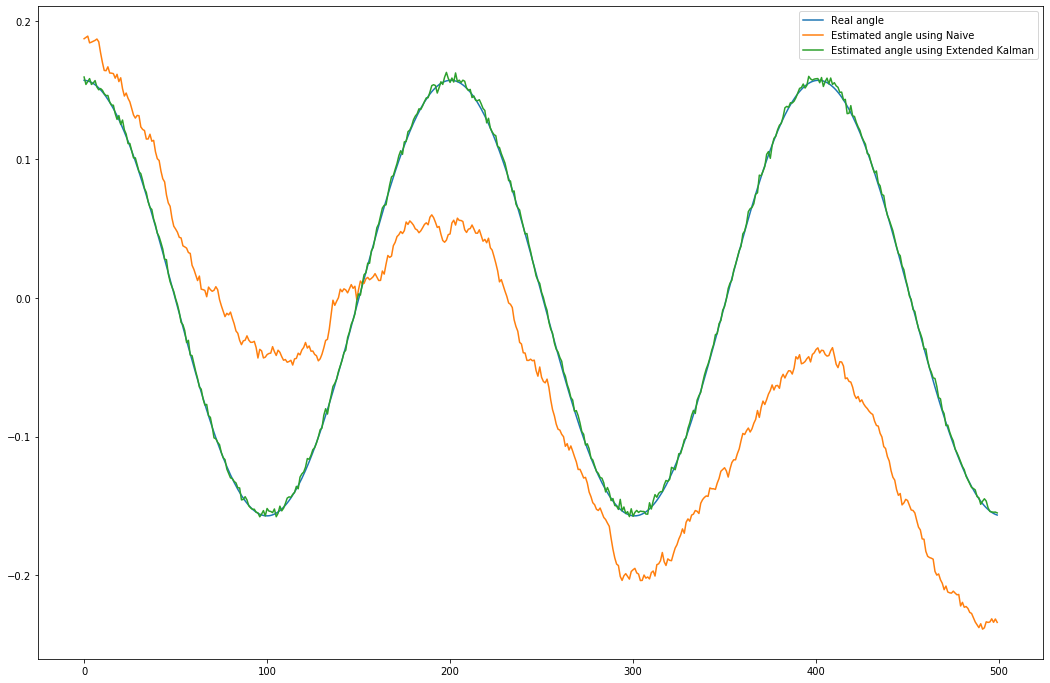

In [16]:
def computeRMS(estimated_angleList, real_angleList):
    return np.sqrt(np.sum((np.array(estimated_angleList)-np.array(real_angleList))**2))

(e_aListNaive, e_penLenNaive, e_vxBiasNaive, e_alBiasNaive, e_avBiasNaive) = estimateGyroNaive(inData, iAngle+iAngleError, pLen+pLenError, g)
(e_aList, e_penLen, e_vxBias, e_alBias, e_avBias, e_penLenBias, angle_speed_cov) = estimateGyro(inData, iAngle+iAngleError, pLen+pLenError, g)

fig, ax = plt.subplots(figsize=figSize)
ax.plot(angleList, label='Real angle') # the real angle
ax.plot(e_aListNaive, label='Estimated angle using Naive') # the naive estimated angle
ax.plot(e_aList, label='Estimated angle using Extended Kalman')   # the estimated angle, obviously drifting due to gyroBias (constant error in the angular velocity speed)
ax.legend()

# print('RMS Naive Angle Estimation Error:', computeRMS(e_aListNaive, angleList))
# print()

print('RMS Angle Estimation Error:', computeRMS(e_aList, angleList))
print()

print('Estimated position/speed covariance:', angle_speed_cov)
print()

print('Estimated Pendulum Length:',e_penLen,' Real Penndulum length:', pLen)
print('Estimated Pendulum bias:',e_penLenBias,' Real Penndulum bias:', pLenError)
print()

print('Estimated Radar bias:', e_vxBias,' Real Radar bias:', vxBias)
print('Estimated AccL bias:', e_alBias,'  Real AccL bias:', alBias)
print('Estimated AccV bias:', e_avBias,'  Real AccV bias:', avBias)


### Remarks on results

1. The system is pretty accurate for $ vxSS \in [0, 1.0] $ and $ alSS \in [0, 1.0] $
2. The Kalman Filter is succesfully estimating even with initial angle error and pendulum length error. (I have tried various pLen and pLenError values such as (1, 0.2), (1, 0.5), (5.0, 1.0) and  and the RMS was under 0.2)
3. This implementation of Kalman filter is sensitive to avSS value. (up to 0.2 it does a nice job, after this value the output is still succesfully following the real graph, but it's more noisy). This behaviour is due to the fact that for small angles, av is rather small also. The error should be small enough also to be properly corrected.
4. The Kalman filter rejects the systematic errors. I tried to approximate them, but I did not succeed to have decent results. 

### References

1. http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/#mjx-eqn-kalpredictfull
2. https://github.com/sharathsrini/Kalman-Filter-for-Sensor-Fusion/blob/master/Kalman_Filter.ipynb
3. https://robottini.altervista.org/kalman-filter-vs-complementary-filter
4. https://www.thepoorengineer.com/en/angle-control-absolute/#kalmanAccelGyro
5. https://robottini.altervista.org/wp-content/uploads/2014/04/filter.pdf